<a href="https://colab.research.google.com/github/jumafernandez/visualizacion-itba/blob/main/N031_Modelo_Ben_Fry_(Reddit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🔍 El modelo de visualización de Ben Fry

Este trabajo está inspirado en el modelo de visualización de información propuesto por **Ben Fry**, uno de los pioneros en visualización interactiva y co-creador de Processing.

Fry plantea que visualizar datos no es solo "hacer gráficos", sino un proceso iterativo y completo compuesto por **siete etapas**:

---

### 📊 Las 7 etapas del modelo de Ben Fry:

| Nº | Etapa        | Propósito                                             |
|----|--------------|-------------------------------------------------------|
| 1️⃣ | Acquire      | Obtener los datos desde una fuente                   |
| 2️⃣ | Parse        | Estructurar los datos de forma manipulable           |
| 3️⃣ | Filter       | Eliminar ruido o datos irrelevantes                  |
| 4️⃣ | Mine         | Detectar patrones, relaciones o información útil     |
| 5️⃣ | Represent    | Elegir una forma visual para mostrar los datos       |
| 6️⃣ | Refine       | Mejorar estética y claridad del gráfico              |
| 7️⃣ | Interact     | Hacer que el usuario explore los datos libremente    |

---

En este proyecto, aplicamos estas etapas para comparar la percepción pública de **Lionel Messi** y **Diego Maradona** en Reddit, usando herramientas de procesamiento de texto, análisis de sentimiento y visualización.

Cada etapa está señalizada en esta notebook para que puedas seguir el proceso completo de transformación de los datos en información visual útil.


# ⚽ Comparación de opiniones sobre Messi y Maradona usando Reddit

Este proyecto explora cómo son percibidos **Lionel Messi** y **Diego Maradona** por la comunidad de Reddit 🧠. Para eso, aplicamos el modelo de visualización de **Ben Fry**, que guía el proceso desde la adquisición de datos hasta su presentación final.

---

## 🔎 ¿Qué es Reddit?

Reddit es una plataforma de foros organizada en comunidades llamadas *subreddits*. Dentro de cada subreddit, los usuarios publican contenido y participan en conversaciones sobre múltiples temas 🌐.

En este proyecto recolectamos publicaciones textuales que mencionan a **Messi** o **Maradona** en comunidades relacionadas al fútbol, con el objetivo de comparar la opinión pública expresada en esos espacios.


In [1]:
# 🔁 Parámetro global para decidir si usar la API de Reddit o cargar CSV
usar_api = True

## 1️⃣ Acquire – Adquisición de datos 🗂️

**Objetivo:** Obtener datos desde una fuente relevante.

**En este proyecto:** Usamos la API de Reddit a través de `praw` para recolectar publicaciones que mencionan a **Messi** o **Maradona**.

📌 Para garantizar variedad y calidad:

- Exploramos múltiples subreddits (`r/soccer`, `r/argentina`, `r/futbol`, etc.)
- Filtramos por año
- Establecimos un límite máximo por jugador

Este paso sienta las bases para todo el análisis posterior.

### 📦 Importación de librerías y configuración inicial
En las próximas dos celdas instalamos e importamos las librerías necesarias para conectarnos con la API de Reddit y manejar los datos.

In [2]:
!pip install praw
!pip install langdetect
!pip install transformers torch --quiet

In [3]:
import warnings
import praw
from getpass import getpass
import pandas as pd
from datetime import datetime
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

warnings.filterwarnings("ignore", category=UserWarning)

### 🌍 Conexión con Reddit

Se instancia la conexión con la app de Reddit a través de `praw`.

In [4]:
if usar_api:

  # Se instancia la conexión con Reddit
  reddit = praw.Reddit(
  client_id='v0IM942RjE_5ipXrWZg7xw', # 🔁 Cambiar de acuerdo a la app de cada estudiante
  client_secret='KOiykfuTbBuyO7fCLq9S0iGps3AzbA', # 🔁 Cambiar de acuerdo a la app de cada estudiante
  user_agent='script:script_clase_itba:v1.0 (by u/Correct-District8721)', # 🔁 Cambiar de acuerdo a la app de cada estudiante
  username='Correct-District8721', # 🔁 Cambiar de acuerdo a la cuenta de Reddit de cada estudiante
  password=getpass('Contraseña de Reddit: ')
)

Contraseña de Reddit: ··········


Se verifica la conexión:

In [5]:
if usar_api:
  print(reddit.user.me())  # 👉 debería mostrar tu usuario y confirmar la conexión

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Correct-District8721


### 🌍 Detección automática del idioma
Creamos una función para detectar si el texto está en español, usando `langdetect`.

In [6]:
def detectar_idioma(texto):
    try:
        return detect(texto)
    except LangDetectException:
        return "unknown"

### 🖥️ Recuperación de posts desde Reddit

Generamos una función general para recuperar posts desde Reddit con la librería `praw`.

In [7]:
def buscar_posts(query, subreddit='soccer', cantidad=300, max_limite=3000,
                 idioma_filtrado='es',
                 fecha_inicio='01/01/2024', fecha_fin='31/12/2024'):

    # Convertir strings a datetime (formato argentino)
    fecha_inicio_dt = datetime.strptime(fecha_inicio, '%d/%m/%Y')
    fecha_fin_dt = datetime.strptime(fecha_fin, '%d/%m/%Y')

    posts = []
    for post in reddit.subreddit(subreddit).search(query, sort='new', limit=max_limite):
        texto = post.selftext
        if texto and len(texto) > 10:
            fecha_post = datetime.utcfromtimestamp(post.created_utc)
            if fecha_inicio_dt <= fecha_post <= fecha_fin_dt:
                idioma_post = detectar_idioma(texto)
                if idioma_post == idioma_filtrado:
                    posts.append({
                        "titulo": post.title,
                        "texto": texto,
                        "autor": str(post.author),
                        "fecha": fecha_post,
                        "score": post.score,
                        "comentarios": post.num_comments,
                        "link": post.url,
                        "jugador": query
                    })
                    if len(posts) >= cantidad:
                        break
    return pd.DataFrame(posts)

### 🗃️ Recuperación desde diferentes subreddit

Generamos una función que utiliza la función `buscar_posts` para recuperar posts desde diferentes Subreddits.

In [8]:
def buscar_posts_multi_subreddits(query, subreddits, cantidad=300, max_limite=1000, idioma_filtrado='es', fecha_i='01/01/2024', fecha_f='31/12/2024'):
    posts = []
    for sub in subreddits:
        print(f"Buscando en r/{sub}...")
        df_temp = buscar_posts(query, subreddit=sub, cantidad=cantidad, max_limite=max_limite, idioma_filtrado=idioma_filtrado, fecha_inicio=fecha_i, fecha_fin=fecha_f)
        posts.extend(df_temp.to_dict('records'))
        if len(posts) >= cantidad:
            break
    return pd.DataFrame(posts[:cantidad])

### 📂 Lista de subreddits relevantes
Acá definimos en qué comunidades vamos a buscar menciones.

In [9]:
subreddits_es = ['soccer', 'argentina', 'futbol']

## 2️⃣ Parse – Estructuración 🧱

**Objetivo:** Organizar los datos en una estructura manipulable.

**En este proyecto:** Convertimos los resultados en un `DataFrame` de Pandas, con campos clave como:

- `texto`
- `fecha`
- `jugador`
- `score`
- `comentarios`

Esto nos permite aplicar filtros, transformaciones y visualizaciones fácilmente.

## 3️⃣ Filter – Filtrado 🧹

**Objetivo:** Eliminar ruido y datos irrelevantes.

**En este proyecto:** Aplicamos filtros para conservar solo publicaciones útiles:

- Idioma español (usamos `langdetect`)
- Año 2024
- Textos con contenido mínimo

Esto garantiza una muestra más precisa y significativa.

In [10]:
if usar_api:
  df_messi_es = buscar_posts_multi_subreddits("Messi", subreddits=subreddits_es, cantidad=300, max_limite=10000, fecha_i='01/01/2023')
  df_messi_es.shape

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Buscando en r/soccer...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Buscando en r/argentina...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Buscando en r/futbol...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [11]:
if usar_api:
  df_maradona_es = buscar_posts_multi_subreddits("Maradona", subreddits=subreddits_es, cantidad=300, max_limite=10000, fecha_i='01/01/2021')
  df_maradona_es.shape

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Buscando en r/soccer...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Buscando en r/argentina...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Buscando en r/futbol...


In [12]:
if usar_api:
    df = pd.concat([df_messi_es, df_maradona_es]).reset_index(drop=True)
    df.to_csv("posts.csv", index=False)
    files.download("posts.csv")
else:
    print("📁 Cargar archivo posts.csv manualmente")
    uploaded = files.upload()
    df = pd.read_csv("posts.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
df.shape

(137, 8)

In [14]:
df

,titulo,texto,autor,fecha,score,comentarios,link,jugador
0,Post-Match Thread: Argentina 1-0 Peru | World ...,FT: Argentina 1-0 Peru\nVenue: Alberto José Ar...,GreatSpaniard,2024-11-20 02:11:34,65,35,https://www.reddit.com/r/soccer/comments/1gveq...,Messi
1,Ustedes creen que messi sera el ultimo mejor j...,Pues aca pensando eso es una pregunta que me h...,InnerDay8650,2024-10-22 04:02:11,0,37,https://www.reddit.com/r/argentina/comments/1g...,Messi
2,"Argentinos, ¿que les impresiona mas","Que lo ven como más impresionante, el mundial ...",Flaky399,2024-10-05 05:26:43,1,18,https://www.reddit.com/r/argentina/comments/1f...,Messi
3,Gracias Argentina,De parte de todos los venezolanos. Gracias Arg...,alfequilu,2024-08-08 17:54:37,41,20,https://www.reddit.com/r/argentina/comments/1e...,Messi
4,La pagina que hice salio el OLGA,Creo que titulo es bastante auto explicativo a...,Mafixo,2024-08-02 22:19:41,0,1,https://www.reddit.com/r/argentina/comments/1e...,Messi
...,...,...,...,...,...,...,...,...
132,Comparación de Diego Armando Maradona y Lionel...,\n\nComparar a Diego Maradona y Lionel Messi ...,Fit-Setting-9663,2023-01-11 08:09:49,0,13,https://www.reddit.com/r/futbol/comments/108zf...,Maradona
133,"Muere 'O rei' Pelé, leyenda del fútbol brasileño",&#x200B;\n\nhttps://preview.redd.it/d7ho9o23yv...,wertyrick,2022-12-29 19:07:46,8,0,https://www.reddit.com/r/futbol/comments/zydfh...,Maradona
134,Que bien le hará al fútbol que los dos más gra...,Sinceramente la figura de Maradona jamás ha si...,skarpelo,2022-12-18 15:48:09,19,28,https://www.reddit.com/r/futbol/comments/zp1h5...,Maradona
135,Opinión poco popular,Maradona es uno de los jugadores más important...,Wild-Butterscotch213,2022-07-29 06:13:10,11,13,https://www.reddit.com/r/futbol/comments/wax1y...,Maradona


## 4️⃣ Mine – Análisis de sentimiento 💬

**Objetivo:** Extraer valor o patrones desde los datos.

**En este proyecto:** Aplicamos un modelo de `transformers` multilingüe (`bert-base-multilingual-uncased-sentiment`) para estimar el **sentimiento** de cada post.

🔢 El modelo devuelve una escala de **1 a 5 estrellas**:
- ⭐ 1 = muy negativo
- ⭐ 3 = neutral
- ⭐ 5 = muy positivo

Así logramos cuantificar el tono emocional de las opiniones expresadas.

### 🤖 Carga del modelo de sentimiento
Usamos un modelo preentrenado para analizar el tono emocional de cada publicación.

In [15]:
from transformers import pipeline

clasificador = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use cpu


### 📊 Función para aplicar el modelo de sentimiento
Toma un texto y devuelve la predicción del modelo (de 1 a 5 estrellas).

In [16]:
def sentimiento_transformers(texto):
    try:
        resultado = clasificador(texto[:512])[0]  # Limita a 512 tokens
        return resultado['label']
    except:
        return "error"

### 🧪 Aplicación del análisis de sentimiento
Agregamos una columna al DataFrame con las estrellas estimadas para cada post.

In [17]:
df['sentimiento_stars'] = df['texto'].apply(sentimiento_transformers)
df['sentimiento_stars'].value_counts()


,count
sentimiento_stars,
1 star,50
5 stars,43
2 stars,22
4 stars,11
3 stars,11


In [18]:
# prompt: quisiera mostrar los textos de df, el jugador (como primera columna) y la cantidad de estrellas. Quisiera el texto completo y no cortado en pantalla.

import pandas as pd

df[['jugador', 'titulo', 'sentimiento_stars']]


,jugador,titulo,sentimiento_stars
0,Messi,Post-Match Thread: Argentina 1-0 Peru | World ...,4 stars
1,Messi,Ustedes creen que messi sera el ultimo mejor j...,3 stars
2,Messi,"Argentinos, ¿que les impresiona mas",5 stars
3,Messi,Gracias Argentina,1 star
4,Messi,La pagina que hice salio el OLGA,2 stars
...,...,...,...
132,Maradona,Comparación de Diego Armando Maradona y Lionel...,5 stars
133,Maradona,"Muere 'O rei' Pelé, leyenda del fútbol brasileño",1 star
134,Maradona,Que bien le hará al fútbol que los dos más gra...,2 stars
135,Maradona,Opinión poco popular,1 star


Transformamos esas estrellas a un valor entero:

In [19]:
df['sentimiento'] = df['sentimiento_stars'].str.extract('(\d)').astype(int)

In [20]:
df['sentimiento'].value_counts()

,count
sentimiento,
1,50
5,43
2,22
4,11
3,11


In [21]:
df.to_csv("posts_con_sentimiento.csv", index=False)
files.download("posts_con_sentimiento.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5️⃣ Represent – Visualización 📊

**Objetivo:** Mostrar los datos de manera clara y comprensible.

**En este proyecto:** Visualizamos la distribución del sentimiento con gráficos de barras:

- Usamos proporciones en lugar de cantidades absolutas
- Aplicamos una paleta de colores inspirada en la camiseta argentina 🇦🇷
- Incluimos etiquetas con porcentajes en cada barra

Esto permite comparar visualmente la percepción pública de cada jugador.

### 🧪 Aplicación del análisis de sentimiento
Agregamos una columna al DataFrame con las estrellas estimadas para cada post.

In [22]:
# Asegurarse de que los valores sean enteros
df['sentimiento'] = df['sentimiento'].astype(int)

# Calcular conteo
conteo = df.groupby(['jugador', 'sentimiento']).size().reset_index(name='cantidad')

# Calcular % por jugador
total_por_jugador = conteo.groupby('jugador')['cantidad'].transform('sum')
conteo['porcentaje'] = conteo['cantidad'] / total_por_jugador * 100

conteo

,jugador,sentimiento,cantidad,porcentaje
0,Maradona,1,19,31.666667
1,Maradona,2,10,16.666667
2,Maradona,3,6,10.000000
3,Maradona,4,6,10.000000
4,Maradona,5,19,31.666667
5,Messi,1,31,40.259740
6,Messi,2,12,15.584416
7,Messi,3,5,6.493506
8,Messi,4,5,6.493506
9,Messi,5,24,31.168831


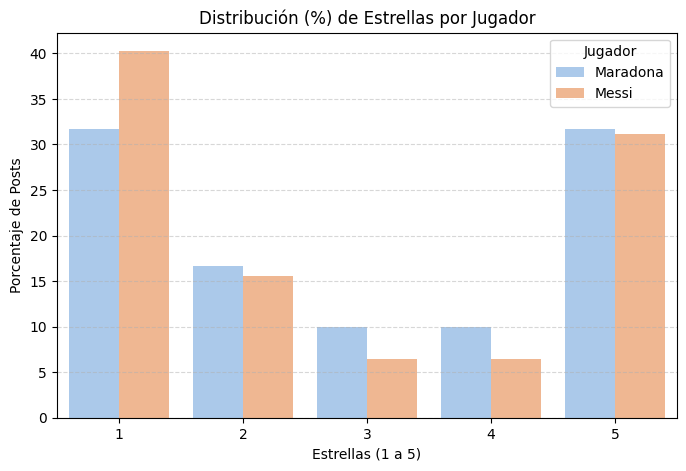

In [23]:
# Graficar
orden_estrellas = [1, 2, 3, 4, 5]

plt.figure(figsize=(8, 5))
sns.barplot(data=conteo, x='sentimiento', y='porcentaje', hue='jugador', order=orden_estrellas, palette='pastel')
plt.title('Distribución (%) de Estrellas por Jugador')
plt.xlabel('Estrellas (1 a 5)')
plt.ylabel('Porcentaje de Posts')
plt.legend(title='Jugador')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 6️⃣ Refine – Refinamiento visual 🎨

**Objetivo:** Mejorar estética y legibilidad.

**En este proyecto:** Ajustamos detalles gráficos para lograr una presentación profesional:

- Límites del eje Y más amplios
- Leyendas alineadas y fuera del gráfico
- Bordes en las barras
- Etiquetas claras y bien posicionadas


In [24]:
colores_arg = ['#005AA7', '#75AADB']  # Azul Maradona, celeste Messi

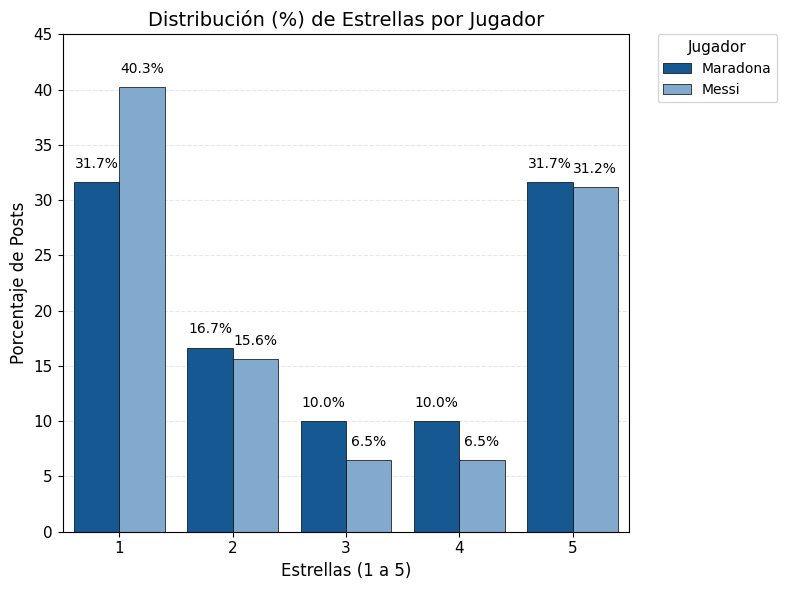

In [25]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=conteo,
    x='sentimiento',
    y='porcentaje',
    hue='jugador',
    order=[1, 2, 3, 4, 5],
    palette=colores_arg,
    edgecolor='black',     # 👈 Borde negro
    linewidth=0.5,         # 👈 Grosor del borde
    zorder=2
)

# Ejes y títulos
plt.title('Distribución (%) de Estrellas por Jugador', fontsize=14)
plt.xlabel('Estrellas (1 a 5)', fontsize=12)
plt.ylabel('Porcentaje de Posts', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 45)

# Grid en segundo plano
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=1)

# Leyenda alineada afuera
plt.legend(
    title='Jugador',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=10,
    title_fontsize=11
)

# Etiquetas por encima
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width() / 2, height + 1),
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## 7️⃣ Interact – Exploración dinámica 🧭

**Objetivo:** Permitir al usuario explorar los datos por sí mismo.

**En este proyecto:** Creamos un gráfico interactivo con `Plotly Express`:

- Tooltip dinámico al pasar el mouse
- Posibilidad de activar/desactivar jugadores
- Visual atractivo y limpio para presentación o dashboard

Esta etapa mejora la exploración y la autonomía del usuario final.

### 🌐 Gráfico interactivo con Plotly
Generamos una visualización que permite explorar los datos dinámicamente.

In [26]:
import plotly.express as px

# Redondear el texto como string con '%'
conteo['texto_pct'] = conteo['porcentaje'].round(1).astype(str) + '%'

# Crear gráfico
fig = px.bar(
    conteo,
    x='sentimiento',
    y='porcentaje',
    color='jugador',
    barmode='group',
    text='texto_pct',
    color_discrete_sequence=colores_arg,
    labels={
        'sentimiento': 'Estrellas',
        'porcentaje': 'Porcentaje',
        'jugador': 'Jugador'
    },
    title='Distribución (%) de Estrellas por Jugador',
    hover_data={'texto_pct': False, 'porcentaje': True}
)

# Estética y ajustes visuales
fig.update_traces(
    textposition='outside',
    textfont_size=12
)
fig.update_layout(
    yaxis_range=[0, 45],
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=12),
    legend=dict(
        title='Jugador',
        x=1.02,
        y=1,
        bordercolor='gray',
        borderwidth=0.5
    )
)

fig.show()